In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir
from scipy.stats import norm
import seaborn as sns

DATA_DIR = get_data_dir()
root_dir = DATA_DIR

WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [9]:
#Human Master Dataframe
ROOT = DATA_DIR  # assumes DATA_DIR is already defined
folders = ["50_50", "80_20", "100_0"]

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def df_to_pdf(df, filename):
    df = df.round(3)
    fig, ax = plt.subplots(figsize=(12, len(df)*0.4 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')


# Combine human CSVs from each condition folder
human_master = pd.concat(
    [pd.read_csv(ROOT / f / "human_data.csv") for f in folders],
    ignore_index=True
)

# Map condition codes
human_master["condition"] = human_master["condition"].map({
    "condition_1": "80_20",
    "condition_2": "50_50",
    "condition_3": "100_0"
})

# Keep / order desired columns
cols = [
    "stimID", "condition", "response", "side_selected", "cue_points",
    "line1_angle", "line2_angle", "valid_cue", "TP", "participantID"
]
human_master = human_master[cols]
human_master["decision"] = (human_master["response"] >= 4).astype(int)

display(human_master)


,stimID,condition,response,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,participantID,decision
0,100,50_50,6,1,2,14.314827,1.921956,False,True,SA,1
1,845,50_50,5,1,2,15.054317,4.222230,False,True,SA,1
2,245,50_50,4,1,1,14.314827,6.508956,True,True,SA,1
3,72,50_50,4,2,2,8.775056,15.054317,True,True,SA,1
4,469,50_50,4,2,2,4.222230,19.885165,True,True,SA,1
...,...,...,...,...,...,...,...,...,...,...,...
35995,698,100_0,5,1,1,11.159944,6.508956,True,False,BC,1
35996,910,100_0,5,1,2,9.651833,4.986334,False,False,BC,1
35997,880,100_0,5,2,2,4.222230,8.775056,True,False,BC,1
35998,53,100_0,5,2,2,4.986334,11.908300,True,False,BC,1


In [11]:
# model master
from pyexpat import model
import pandas as pd
from pathlib import Path
from _utils import get_data_dir

ROOT = get_data_dir()
conds = ["50_50", "80_20", "100_0"]
dfs = []

def load_decisions(path, cond, model):
    df = pd.read_csv(path)
    df["stimID"] = df["image_id"]
    df["condition"] = cond
    df["participantID"] = model
    df["response"] = (
        df["GPT_response"].astype(str).str.strip().str.lower()
        .replace({"true": "present", "false": "absent"})
    )
    df["decision"] = df["response"].map({"present": 1, "absent": 0})
    return df[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]]

def df_to_pdf(df, filename):
    df = df.round(3)
    fig, ax = plt.subplots(figsize=(12, len(df)*0.4 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')

def parse_gemini(resp):
    a1, a2, dec = [p.strip() for p in str(resp).split(",")]
    return float(a1), float(a2), dec.lower()

for cond in conds:
    base = ROOT / cond

    # all decision models — now using decisions_fixed
    decisions_dir = base / "decisions_fixed"
    if not decisions_dir.exists():
        print(f"[WARN] {decisions_dir} not found, falling back to 'decisions' for {cond}")
        decisions_dir = base / "decisions"

    for f in decisions_dir.glob("*.csv"):
        dfs.append(load_decisions(f, cond, f.stem))

    # gemini angle-estimation model (unchanged)
    g = pd.read_csv(base / "angle_estimations" / "gemini-2.5-pro.csv")
    g[["est1", "est2", "response"]] = pd.DataFrame(
        g["GPT_response"].apply(parse_gemini).tolist(), index=g.index
    )
    g["stimID"] = g["image_id"]
    g["condition"] = cond
    g["participantID"] = "gemini-2.5-pro"
    g["decision"] = g["response"].map({"present": 1, "absent": 0})
    dfs.append(g[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]])

model_master = pd.concat(dfs, ignore_index=True)

bad_model = "0responses_gemini-2.5-flash-lite-preview-06-17"
model_master = model_master[ model_master["participantID"] != bad_model ]

display(model_master)

,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
0,100,50_50,1,2,14.314827,1.921956,False,True,present,0responses_claude-3-5-haiku-20241022,1
1,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_claude-3-5-haiku-20241022,0
2,245,50_50,1,1,14.314827,6.508956,True,True,present,0responses_claude-3-5-haiku-20241022,1
3,72,50_50,2,2,8.775056,15.054317,True,True,absent,0responses_claude-3-5-haiku-20241022,0
4,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_claude-3-5-haiku-20241022,0
...,...,...,...,...,...,...,...,...,...,...,...
38995,698,100_0,1,1,11.159944,6.508956,True,False,present,gemini-2.5-pro,1
38996,910,100_0,1,2,9.651833,4.986334,False,False,absent,gemini-2.5-pro,0
38997,880,100_0,2,2,4.222230,8.775056,True,False,absent,gemini-2.5-pro,0
38998,53,100_0,2,2,4.986334,11.908300,True,False,present,gemini-2.5-pro,1


In [13]:
#Group Size vs Human and Model Majority Analysis
group_sizes = [1, 3, 5, 7, 11, 12]
n_boot = 500
rng = np.random.default_rng(seed=42)

conds = ["50_50", "80_20", "100_0"]

human_df = human_master.copy()   # as described
model_df = model_master.copy()   # same schema but only 'decision' is meaningful

# Optional: where to save results
out_dir = Path(r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs")
out_dir.mkdir(parents=True, exist_ok=True)
results_path = out_dir / "human_model_majority_bootstrap_results.csv"
summary_path = out_dir / "human_model_majority_summary.csv"


# ------------- HELPERS -------------
def majority_conf_vectorized(dec_mat, conf_mat, tp_vec):
    """
    Human rule: majority on decisions with confidence (response) tiebreak.
    dec_mat:  (T, G) decisions {0,1} or NaN
    conf_mat: (T, G) confidence ratings or NaN
    tp_vec:   (T,)   ground truth {0,1}
    """
    present_counts = np.nansum(dec_mat == 1, axis=1)
    absent_counts  = np.nansum(dec_mat == 0, axis=1)

    gd = np.full(dec_mat.shape[0], np.nan)

    present_wins = present_counts > absent_counts
    absent_wins  = absent_counts > present_counts

    gd[present_wins] = 1
    gd[absent_wins]  = 0

    # Ties
    ties = ~(present_wins | absent_wins)

    if np.any(ties):
        dec_tie  = dec_mat[ties]
        conf_tie = conf_mat[ties]

        # mean confidence for present
        mask_present = (dec_tie == 1)
        with np.errstate(invalid="ignore"):
            conf_present_mean = np.where(
                mask_present.any(axis=1),
                np.nanmean(np.where(mask_present, conf_tie, np.nan), axis=1),
                np.nan
            )

        # mean confidence for absent
        mask_absent = (dec_tie == 0)
        with np.errstate(invalid="ignore"):
            conf_absent_mean = np.where(
                mask_absent.any(axis=1),
                np.nanmean(np.where(mask_absent, conf_tie, np.nan), axis=1),
                np.nan
            )

        tie_idx = np.where(ties)[0]

        pres_better = conf_present_mean > conf_absent_mean
        gd[tie_idx[pres_better]] = 1

        abs_better = conf_absent_mean > conf_present_mean
        gd[tie_idx[abs_better]] = 0

        # unresolved (perfect tie / all NaN) -> default to 1
        unresolved = np.isnan(gd[tie_idx])
        gd[tie_idx[unresolved]] = 1

    correct = gd == tp_vec
    mask_valid = ~np.isnan(tp_vec)
    acc = correct[mask_valid].mean()
    return float(acc)


def majority_vectorized(dec_mat, tp_vec):
    """
    Model rule: simple majority on decisions. Ties default to 1.
    dec_mat: (T, G) decisions {0,1} or NaN
    tp_vec:  (T,)   ground truth {0,1}
    """
    present_counts = np.nansum(dec_mat == 1, axis=1)
    absent_counts  = np.nansum(dec_mat == 0, axis=1)

    gd = np.full(dec_mat.shape[0], np.nan)

    present_wins = present_counts > absent_counts
    absent_wins  = absent_counts > present_counts
    ties = ~(present_wins | absent_wins)

    gd[present_wins] = 1
    gd[absent_wins]  = 0
    gd[ties] = 1  # tie → default to 1 (present)

    correct = gd == tp_vec
    mask_valid = ~np.isnan(tp_vec)
    acc = correct[mask_valid].mean()
    return float(acc)


# ------------- HEAVY LOOP (humans + models) -------------
records = []

for domain, df in [("human", human_df), ("model", model_df)]:
    print(f"\n=== DOMAIN: {domain.upper()} ===")

    for cond in conds:
        dfc = df[df["condition"] == cond].copy()
        if dfc.empty:
            print(f"  Condition {cond}: no data, skipping.")
            continue

        # Pivot to trial x participant matrices for decisions
        dec_pivot = dfc.pivot(index="stimID", columns="participantID", values="decision")

        # TP vector aligned with trials
        tp_by_trial = (
            dfc.drop_duplicates("stimID")
               .set_index("stimID")["TP"]
               .reindex(dec_pivot.index)
               .to_numpy()
               .astype(float)
        )

        dec_mat = dec_pivot.to_numpy().astype(float)  # (T, P)
        participants_cond = dec_pivot.columns.to_numpy()
        n_participants = len(participants_cond)

        print(f"  {cond}: {n_participants} participants available")

        valid_group_sizes = [g for g in group_sizes if g <= n_participants]
        if len(valid_group_sizes) < len(group_sizes):
            missing = set(group_sizes) - set(valid_group_sizes)
            print(f"    Skipping group sizes (not enough participants): {sorted(missing)}")

        # For humans, also pivot confidence (response)
        if domain == "human":
            conf_pivot = dfc.pivot(index="stimID", columns="participantID", values="response")
            conf_mat = conf_pivot.to_numpy().astype(float)

        for g in valid_group_sizes:
            for b in range(n_boot):
                cols = rng.choice(n_participants, size=g, replace=False)
                dec_sample = dec_mat[:, cols]

                if domain == "human":
                    conf_sample = conf_mat[:, cols]
                    acc = majority_conf_vectorized(dec_sample, conf_sample, tp_by_trial)
                else:
                    acc = majority_vectorized(dec_sample, tp_by_trial)

                records.append({
                    "domain": domain,
                    "condition": cond,
                    "group_size": g,
                    "bootstrap": b,
                    "accuracy": acc
                })

            print(f"    Finished {cond}, group size {g}")

# Build full results df and summary df
results_df = pd.DataFrame(records)
summary_df = (
    results_df
    .groupby(["domain", "condition", "group_size"])["accuracy"]
    .agg(mean_acc="mean", std_acc="std")
    .reset_index()
)

# Save for reuse later
results_df.to_csv(results_path, index=False)
summary_df.to_csv(summary_path, index=False)

print("\nSaved:")
print("  Full bootstrap results ->", results_path)
print("  Summary stats          ->", summary_path)
summary_df



=== DOMAIN: HUMAN ===
  50_50: 12 participants available
    Finished 50_50, group size 1
    Finished 50_50, group size 3
    Finished 50_50, group size 5
    Finished 50_50, group size 7
    Finished 50_50, group size 11
    Finished 50_50, group size 12
  80_20: 12 participants available
    Finished 80_20, group size 1
    Finished 80_20, group size 3
    Finished 80_20, group size 5
    Finished 80_20, group size 7
    Finished 80_20, group size 11
    Finished 80_20, group size 12
  100_0: 12 participants available
    Finished 100_0, group size 1
    Finished 100_0, group size 3
    Finished 100_0, group size 5
    Finished 100_0, group size 7
    Finished 100_0, group size 11
    Finished 100_0, group size 12

=== DOMAIN: MODEL ===
  50_50: 12 participants available
    Finished 50_50, group size 1
    Finished 50_50, group size 3
    Finished 50_50, group size 5
    Finished 50_50, group size 7
    Finished 50_50, group size 11
    Finished 50_50, group size 12
  80_20: 12 pa

,domain,condition,group_size,mean_acc,std_acc
0,human,100_0,1,0.665576,0.107901
1,human,100_0,3,0.715176,0.070470
2,human,100_0,5,0.740958,0.054125
3,human,100_0,7,0.759498,0.040702
4,human,100_0,11,0.782264,0.012799
5,human,100_0,12,0.784000,0.000000
6,human,50_50,1,0.577740,0.075924
7,human,50_50,3,0.608408,0.058047
8,human,50_50,5,0.627500,0.048021
9,human,50_50,7,0.640844,0.034066


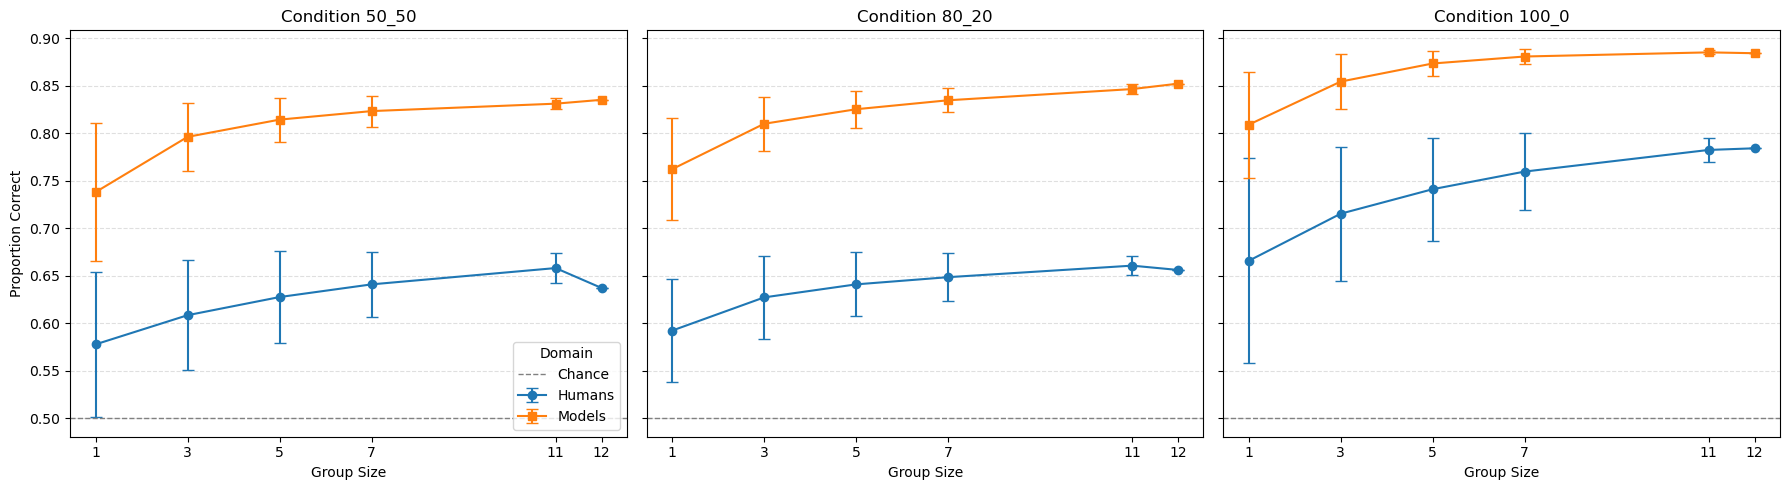

In [15]:
#Group Size vs Human and Model Majority Plotting
out_dir = Path(r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs")
summary_path = out_dir / "human_model_majority_summary.csv"
summary_df = pd.read_csv(summary_path)

conds = ["50_50", "80_20", "100_0"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, cond in zip(axes, conds):
    sub = summary_df[summary_df["condition"] == cond].copy()

    for domain, marker, label in [
        ("human", "o-", "Humans"),
        ("model", "s-", "Models"),
    ]:
        dsub = sub[sub["domain"] == domain].sort_values("group_size")
        if dsub.empty:
            continue

        ax.errorbar(
            dsub["group_size"],
            dsub["mean_acc"],
            yerr=dsub["std_acc"],
            fmt=marker,
            capsize=4,
            label=label
        )
    ax.set_xticks(group_sizes)

    ax.axhline(0.5, color="gray", linestyle="--", linewidth=1, label="Chance")
    ax.set_xlabel("Group Size")
    ax.set_title(f"Condition {cond}")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

axes[0].set_ylabel("Proportion Correct")
axes[0].legend(title="Domain")
plt.tight_layout()

# Optional: save
# fig_path = out_dir / "human_vs_model_majority_by_condition.pdf"
# fig.savefig(fig_path, bbox_inches="tight")

plt.show()
